In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from sklearn.preprocessing import MinMaxScaler

In [83]:
df = pd.read_csv(os.path.join('Data/Stocks','ge.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close', 'Volume'])
print('Loaded data from the Kaggle repository')



Loaded data from the Kaggle repository


In [84]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close,Volume
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430


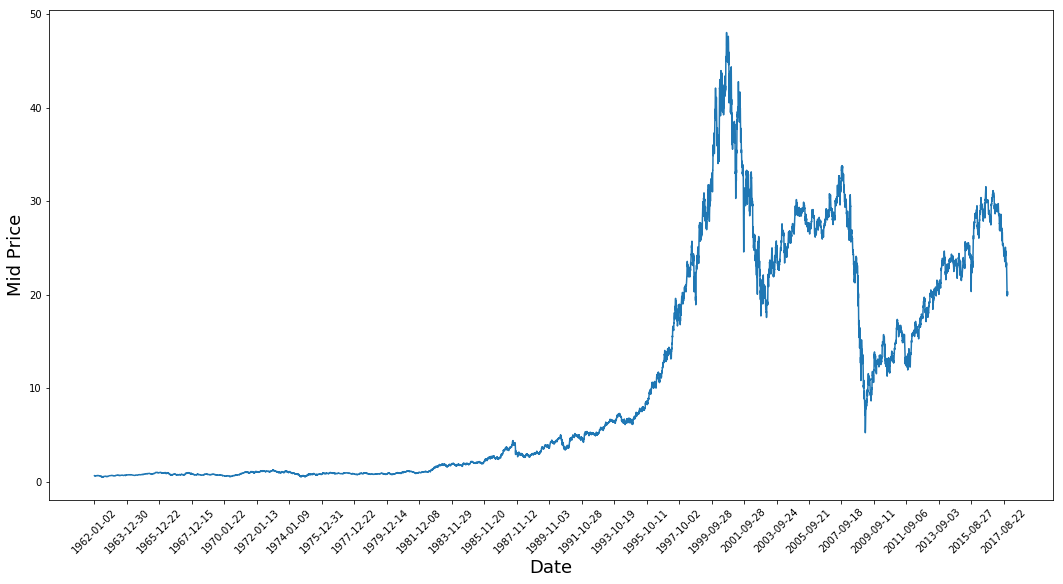

In [85]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [86]:
df['mid'] = (df['Low']+df['High'])/2.0

In [87]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "mid"

In [88]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [89]:
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)

In [90]:
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [91]:
df.head()

,Date,Open,High,Low,Close,Volume,mid,future,target
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0.62815,0.61615,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0.61615,0.61190,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0.61190,0.59600,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0.59600,0.58365,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0.58365,0.59575,1


In [92]:
df.tail()

,Date,Open,High,Low,Close,Volume,mid,future,target
14053,2017-11-06,20.52,20.530,20.08,20.13,60641787,20.3050,20.1850,0
14054,2017-11-07,20.17,20.250,20.12,20.21,41622851,20.1850,20.1950,1
14055,2017-11-08,20.21,20.320,20.07,20.12,39672190,20.1950,19.9605,0
14056,2017-11-09,20.04,20.071,19.85,19.99,50831779,19.9605,20.2900,1
14057,2017-11-10,19.98,20.680,19.90,20.49,100698474,20.2900,NaN,0


In [93]:
times = sorted(df.index.values)  # get the times
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]  # get the last 10% of the times
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]  # get the last 20% of the times

test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]  
train_df = df[(df.index < last_20pct)]  # now the train_df is all the data up to the last 20%

In [94]:
from collections import deque
import numpy as np
import random

In [95]:
train_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
validation_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
test_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)# don't need this anymore.

/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [96]:
train_df.head()

,mid,target
0,0.62815,0
1,0.61615,0
2,0.61190,0
3,0.59600,0
4,0.58365,1


In [97]:
train_data = train_df[RATIO_TO_PREDICT].as_matrix()
valid_data = validation_df[RATIO_TO_PREDICT].as_matrix()
test_data = test_df[RATIO_TO_PREDICT].as_matrix()

/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [98]:
train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)


In [99]:
scaler = MinMaxScaler()

In [100]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [101]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data and validation data
valid_data = scaler.transform(valid_data).reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

In [102]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(11000):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,valid_data, test_data],axis=0)

In [103]:
X_train = []
y_train = []
for i in range(SEQ_LEN, len(train_data)):
    X_train.append(train_data[i-SEQ_LEN:i])
    y_train.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [104]:
X_valid = []
y_valid = []
for i in range(SEQ_LEN, len(valid_data)):
    X_valid.append(valid_data[i-SEQ_LEN:i])
    y_valid.append(valid_data[i+(FUTURE_PERIOD_PREDICT-1)])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [105]:
X_test = []
y_test = []
for i in range(SEQ_LEN, len(test_data)):
    X_test.append(test_data[i-SEQ_LEN:i])
    y_test.append(test_data[i+(FUTURE_PERIOD_PREDICT-1)])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [106]:
y_train.shape

(11187,)

In [107]:
y_valid.shape

(1346,)

In [108]:
X_train_2 = []
y_train_2 = []
for i in range(SEQ_LEN, len(train_data)):
    X_train_2.append(train_data[i-SEQ_LEN:i])
    y_train_2.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train_2, y_train_2 = np.array(X_train_2), np.array(y_train_2)

X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 1))

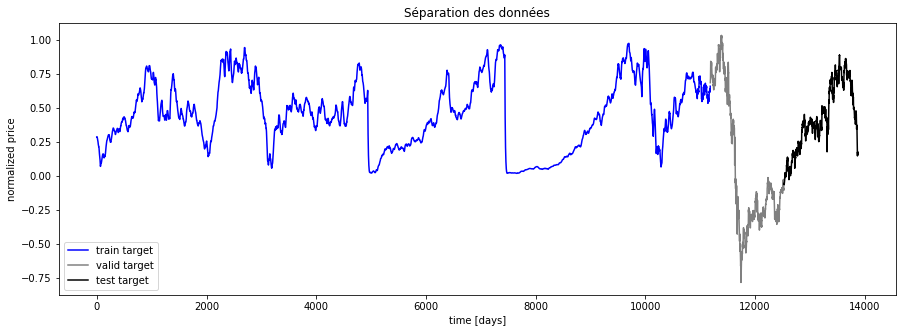

In [109]:
## show predictions
plt.figure(figsize=(15, 5))

plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color='blue', label='train target')

plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0],
                   y_train_2.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('Séparation des données')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

In [110]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

# Baseline : LSTM

In [111]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import GRU
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam 

In [112]:
EPOCHS = 10  # how many passes through our data
BATCH_SIZE = 1024  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
import time

NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [113]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=3, verbose=1)
checkpoint = ModelCheckpoint(NAME, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [114]:
baseline = Sequential()
baseline.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=False, activation='relu'))
baseline.add(Dropout(0.2))
baseline.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

baseline.add(Dense(1, activation='relu'))

In [115]:
baseline.compile(loss='mean_squared_error', optimizer=Adam() , metrics = ['mean_squared_error'])

In [116]:
baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 67,201
Trainable params: 66,945
Non-trainable params: 256
_________________________________________________________________


In [117]:
baseline.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks = [checkpoint, lr_reduce])

Train on 11187 samples, validate on 1346 samples
Epoch 1/10
11187/11187 [==============================] - 36s 3ms/step - loss: 0.1414 - mean_squared_error: 0.1414 - val_loss: 0.1989 - val_mean_squared_error: 0.1989

Epoch 00001: val_loss improved from inf to 0.19890, saving model to 60-SEQ-1-PRED-1544724342
Epoch 2/10
11187/11187 [==============================] - 28s 2ms/step - loss: 0.0816 - mean_squared_error: 0.0816 - val_loss: 0.1457 - val_mean_squared_error: 0.1457

Epoch 00002: val_loss improved from 0.19890 to 0.14568, saving model to 60-SEQ-1-PRED-1544724342
Epoch 3/10
11187/11187 [==============================] - 32s 3ms/step - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.1123 - val_mean_squared_error: 0.1123

Epoch 00003: val_loss improved from 0.14568 to 0.11229, saving model to 60-SEQ-1-PRED-1544724342
Epoch 4/10
11187/11187 [==============================] - 28s 2ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0930 - val_mean_squared_error: 

In [118]:
predicted_stock_price_baseline = baseline.predict(X_test)
#predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
predicted_stock_price_baseline = np.vstack((np.full((60,1), np.nan), predicted_stock_price_baseline))

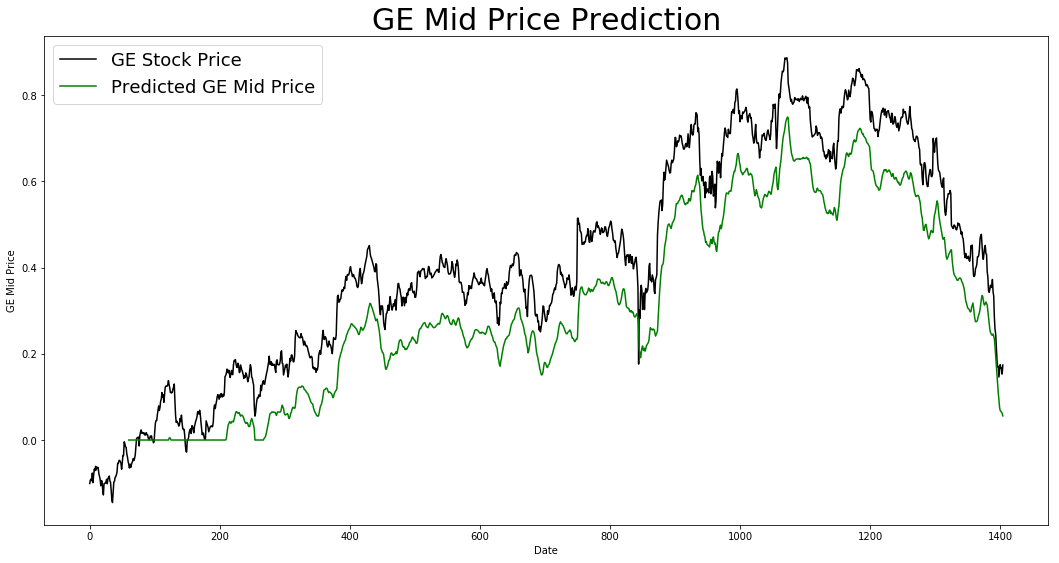

In [119]:
plt.figure(figsize = (18,9))
plt.plot(test_data, color = 'black', label = 'GE Stock Price')
plt.plot(predicted_stock_price_baseline, color = 'green', label = 'Predicted GE Mid Price')
plt.title('GE Mid Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('GE Mid Price')
plt.legend(fontsize=18)
plt.show()

In [120]:
predicted_stock_price_baseline = scaler.inverse_transform(predicted_stock_price_baseline)

In [121]:
predicted_stock_price_baseline[61], test_data[0]

(array([17.552]), -0.1009049055405622)

In [122]:
test_df['predictions_baseline'] = predicted_stock_price_baseline

/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [123]:
test_df['target_predictions_baseline'] = list(map(classify, test_df[RATIO_TO_PREDICT], test_df['predictions_baseline']))

/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [124]:
from sklearn.metrics import accuracy_score

In [125]:
accuracy_score(test_df['target'][61:], test_df['target_predictions_baseline'][61:])

0.5081845238095238

In [126]:
for index, row in test_df[61:].iterrows():
    print(row["target_predictions_baseline"])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# Training a bit further the baseline

In [127]:
EPOCHS_2 = 100  # how many passes through our data
BATCH_SIZE_2 = 1024  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
import time

NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [128]:
history_baseline = baseline.fit(X_train, y_train,
                    batch_size=BATCH_SIZE_2,
                    epochs=EPOCHS_2,
                    validation_data=(X_valid, y_valid), 
                    callbacks = [checkpoint, lr_reduce])

Train on 11187 samples, validate on 1346 samples
Epoch 1/100
11187/11187 [==============================] - 24s 2ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.1039 - val_mean_squared_error: 0.1039

Epoch 00001: val_loss did not improve from 0.09301
Epoch 2/100
11187/11187 [==============================] - 24s 2ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.1066 - val_mean_squared_error: 0.1066

Epoch 00002: val_loss did not improve from 0.09301
Epoch 3/100
11187/11187 [==============================] - 27s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.1093 - val_mean_squared_error: 0.1093

Epoch 00003: val_loss did not improve from 0.09301
Epoch 4/100
11187/11187 [==============================] - 22s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.1118 - val_mean_squared_error: 0.1118

Epoch 00004: val_loss did not improve from 0.09301

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.00000006568

11187/11187 [==============================] - 28s 2ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.1357 - val_mean_squared_error: 0.1357

Epoch 00067: val_loss did not improve from 0.09301

Epoch 00067: ReduceLROnPlateau reducing learning rate to 1.000000142800998e-27.
Epoch 68/100
11187/11187 [==============================] - 23s 2ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.1357 - val_mean_squared_error: 0.1357

Epoch 00068: val_loss did not improve from 0.09301
Epoch 69/100
11187/11187 [==============================] - 26s 2ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.1357 - val_mean_squared_error: 0.1357

Epoch 00069: val_loss did not improve from 0.09301
Epoch 70/100
11187/11187 [==============================] - 24s 2ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.1357 - val_mean_squared_error: 0.1357

Epoch 00070: val_loss did not improve from 0.09301

Epoch 00070: ReduceLROnPlateau reducing learnin

11187/11187 [==============================] - 25s 2ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.1357 - val_mean_squared_error: 0.1357

Epoch 00100: val_loss did not improve from 0.09301

Epoch 00100: ReduceLROnPlateau reducing learning rate to 1.0000001032014561e-38.


In [129]:
predicted_stock_price_baseline = baseline.predict(X_test)
#predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


predicted_stock_price_baseline.shape

(1345, 1)

In [130]:
predicted_stock_price_baseline = np.vstack((np.full((60,1), np.nan), predicted_stock_price_baseline))

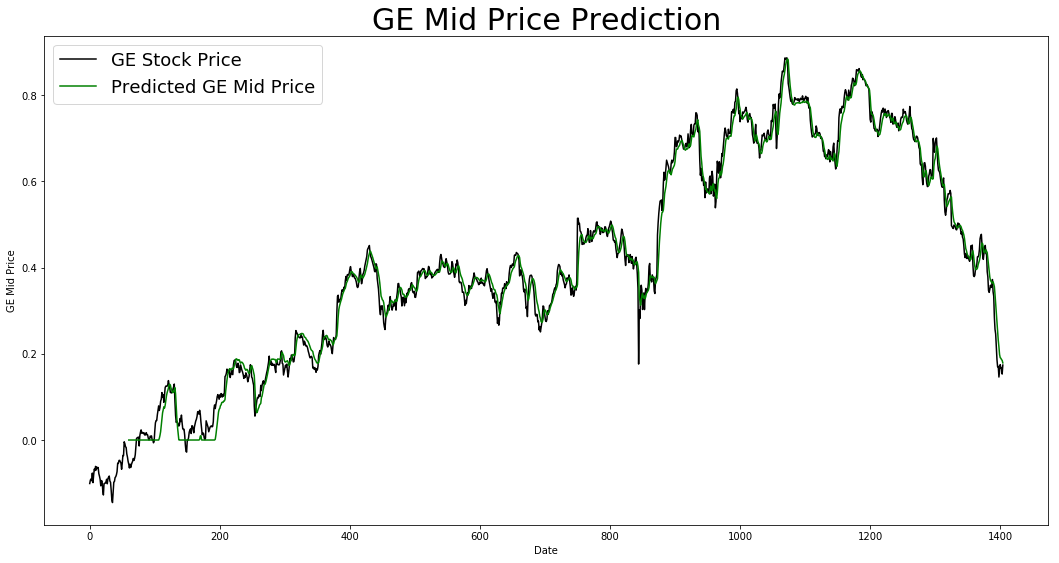

In [131]:
plt.figure(figsize = (18,9))
plt.plot(test_data, color = 'black', label = 'GE Stock Price')
plt.plot(predicted_stock_price_baseline, color = 'green', label = 'Predicted GE Mid Price')
plt.title('GE Mid Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('GE Mid Price')
plt.legend(fontsize=18)
plt.show()

In [132]:
predicted_stock_price_baseline = scaler.inverse_transform(predicted_stock_price_baseline)



test_df['predicted_stock_price_baseline'] = predicted_stock_price_baseline

test_df['target_predictions_baseline'] = list(map(classify, test_df[RATIO_TO_PREDICT], test_df['predicted_stock_price_baseline']))



/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [133]:
accuracy_score(test_df['target'][61:], test_df['target_predictions_baseline'][61:])

0.4583333333333333

In [134]:
for index, row in test_df[61:].iterrows():
    print(row["target_predictions_baseline"])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0


# Moving average

In [135]:
window_size = 60
N = test_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(test_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-test_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00286


In [136]:
predicted_stock_price_baseline = scaler.transform(predicted_stock_price_baseline)

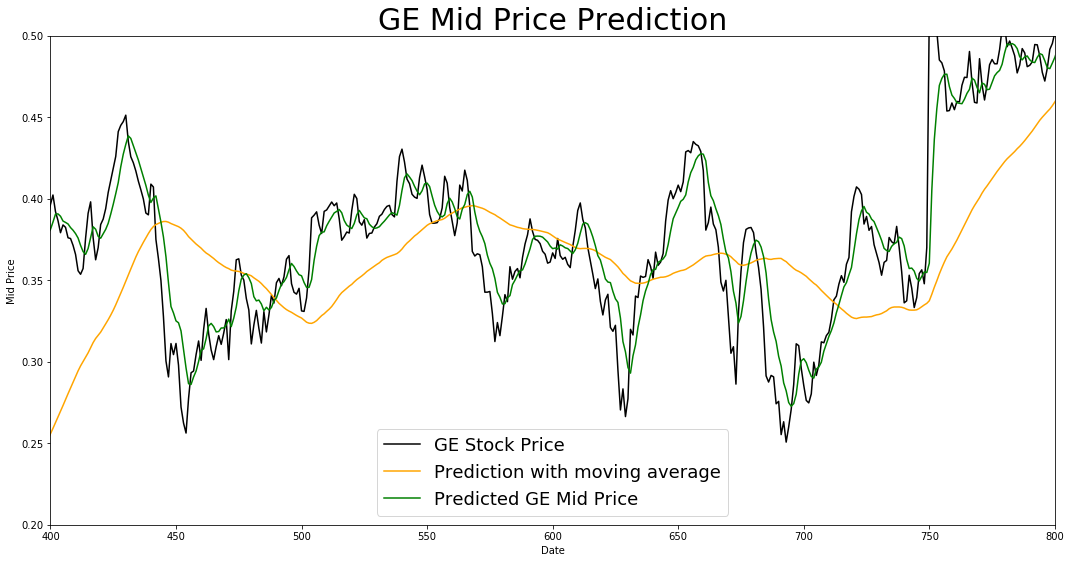

In [182]:
plt.figure(figsize = (18,9))

plt.plot(test_data, color = 'black', label = 'GE Stock Price')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction with moving average')
plt.plot(predicted_stock_price_baseline, color = 'green', label = 'Predicted GE Mid Price')
plt.title('GE Mid Price Prediction', fontsize=30)
plt.axis([400,800,0.2,0.5])
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

# Exponential moving average

In [138]:
window_size = 60
N = test_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*test_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-test_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00019


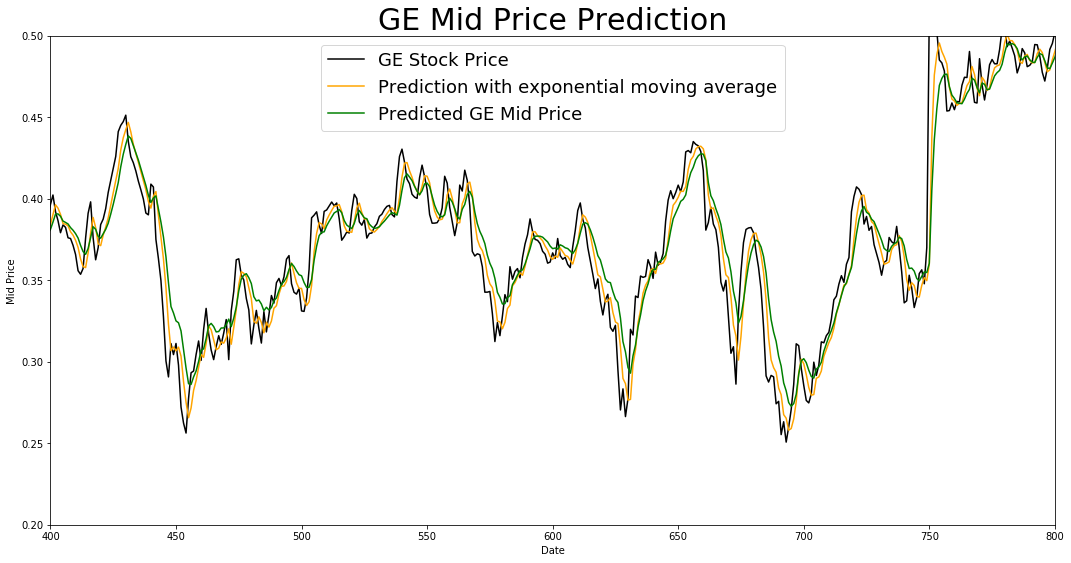

In [183]:
plt.figure(figsize = (18,9))
plt.plot(test_data, color = 'black', label = 'GE Stock Price')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction with exponential moving average')
plt.plot(predicted_stock_price_baseline, color = 'green', label = 'Predicted GE Mid Price')
plt.axis([400,800,0.2,0.5])
plt.title('GE Mid Price Prediction', fontsize=30)
plt.margins(x=0, y=-0.25)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

# LSTM + GRU

In [140]:
filepath="LSTM_GRU.hdf5"

In [141]:
model = Sequential()
model.add(GRU(256 , input_shape = (X_train.shape[1], 1) , return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256))
model.add(Dropout(0.4))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 60, 256)           198144    
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 739,969
Trainable params: 739,969
Non-trainable params: 0
_________________________________________________________________


In [142]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005) , metrics = ['mean_squared_error'])

In [143]:
history_lstm = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid), 
                    callbacks = [checkpoint , lr_reduce])

Train on 11187 samples, validate on 1346 samples
Epoch 1/10
11187/11187 [==============================] - 127s 11ms/step - loss: 0.0672 - mean_squared_error: 0.0672 - val_loss: 0.0490 - val_mean_squared_error: 0.0490

Epoch 00001: val_loss improved from 0.09301 to 0.04900, saving model to 60-SEQ-1-PRED-1544724342
Epoch 2/10
11187/11187 [==============================] - 109s 10ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0388 - val_mean_squared_error: 0.0388

Epoch 00002: val_loss improved from 0.04900 to 0.03877, saving model to 60-SEQ-1-PRED-1544724342
Epoch 3/10
11187/11187 [==============================] - 118s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0358 - val_mean_squared_error: 0.0358

Epoch 00003: val_loss improved from 0.03877 to 0.03579, saving model to 60-SEQ-1-PRED-1544724342
Epoch 4/10
11187/11187 [==============================] - 112s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0315 - val_mean_squ

In [144]:
predicted_stock_price_lstm_gru = model.predict(X_test)
#predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
predicted_stock_price_lstm_gru = np.vstack((np.full((60,1), np.nan), predicted_stock_price_lstm_gru))

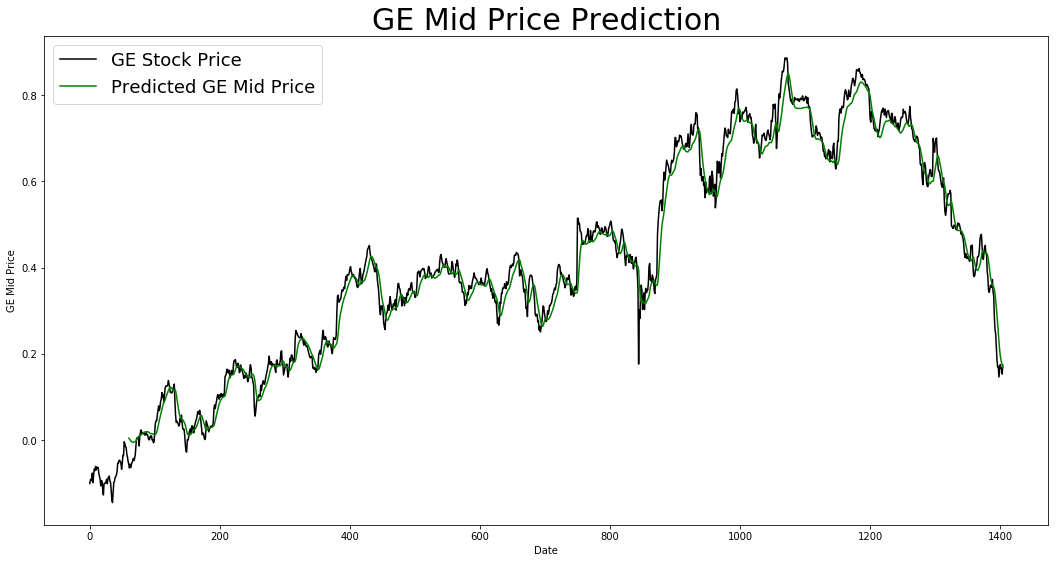

In [145]:
plt.figure(figsize = (18,9))
plt.plot(test_data, color = 'black', label = 'GE Stock Price')
plt.plot(predicted_stock_price_lstm_gru, color = 'green', label = 'Predicted GE Mid Price')
plt.title('GE Mid Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('GE Mid Price')
plt.legend(fontsize=18)
plt.show()

In [146]:
predicted_stock_price_lstm_gru = scaler.inverse_transform(predicted_stock_price_lstm_gru)

In [147]:
predicted_stock_price_lstm_gru[61], test_data[0]

(array([17.59347928]), -0.1009049055405622)

In [148]:
test_df['predicted_stock_price_lstm_gru'] = predicted_stock_price_lstm_gru

/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [149]:
test_df['target_predictions_lstm_gru'] = list(map(classify, test_df[RATIO_TO_PREDICT], test_df['predicted_stock_price_lstm_gru']))

/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [150]:
accuracy_score(test_df['target'][61:], test_df['target_predictions_lstm_gru'][61:])

0.48735119047619047

In [151]:
for index, row in test_df[61:].iterrows():
    print(row["target_predictions_lstm_gru"])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0


# Attention

In [159]:
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.engine.input_layer import Input
from keras import backend as K
from keras.models import Model

In [153]:
# https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [160]:
inp = Input(shape=(SEQ_LEN, 1))
x = LSTM(128, return_sequences=True)(inp)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Attention(SEQ_LEN)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1, activation="relu")(x)
model_lstm_attention = Model(inputs=inp, outputs=x)

In [161]:
model_lstm_attention.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005))

model_lstm_attention.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 60, 1)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 128)           66560     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 60, 128)           512       
_________________________________________________________________
attention_3 (Attention)      (None, 128)               188       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
__________

In [162]:
model_lstm_attention.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid), 
                    #callbacks = [checkpoint , lr_reduce]
             )

Train on 11187 samples, validate on 1346 samples
Epoch 1/10
11187/11187 [==============================] - 62s 6ms/step - loss: 0.1706 - val_loss: 0.1842
Epoch 2/10
11187/11187 [==============================] - 47s 4ms/step - loss: 0.0756 - val_loss: 0.3676
Epoch 3/10
11187/11187 [==============================] - 49s 4ms/step - loss: 0.0487 - val_loss: 0.2013
Epoch 4/10
11187/11187 [==============================] - 46s 4ms/step - loss: 0.0313 - val_loss: 0.2685
Epoch 5/10
11187/11187 [==============================] - 47s 4ms/step - loss: 0.0254 - val_loss: 0.1963
Epoch 6/10
11187/11187 [==============================] - 44s 4ms/step - loss: 0.0217 - val_loss: 0.1028
Epoch 7/10
11187/11187 [==============================] - 39s 3ms/step - loss: 0.0204 - val_loss: 0.0903
Epoch 8/10
11187/11187 [==============================] - 42s 4ms/step - loss: 0.0181 - val_loss: 0.0829
Epoch 9/10
11187/11187 [==============================] - 42s 4ms/step - loss: 0.0175 - val_loss: 0.0871
Epoch 

In [163]:
predicted_stock_price_lstm_attention = model_lstm_attention.predict(X_test)
#predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


predicted_stock_price_lstm_attention.shape

(1345, 1)

In [164]:
predicted_stock_price_lstm_attention = np.vstack((np.full((60,1), np.nan), predicted_stock_price_lstm_attention))

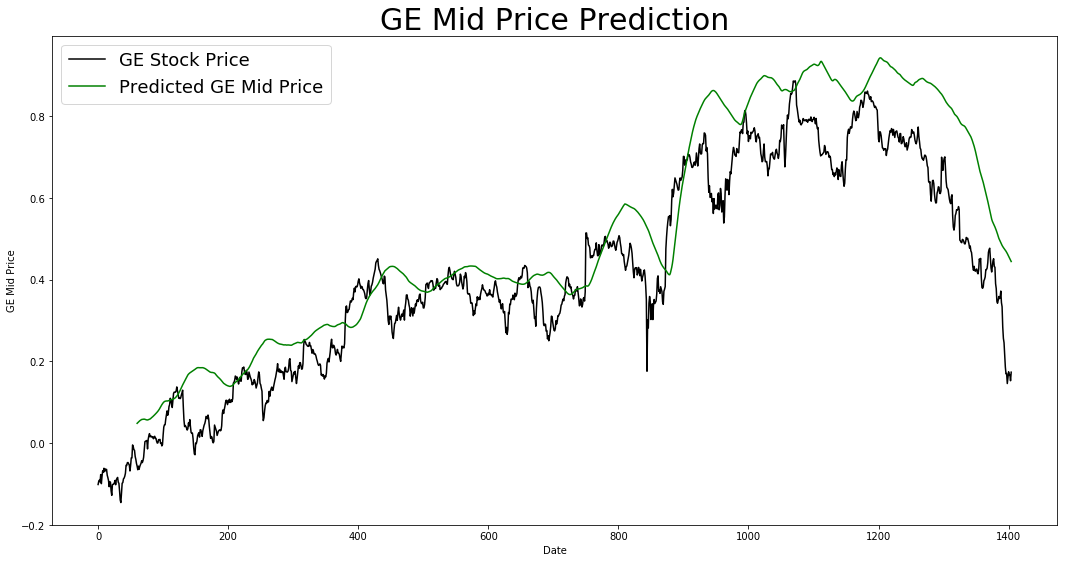

In [165]:
plt.figure(figsize = (18,9))
plt.plot(test_data, color = 'black', label = 'GE Stock Price')
plt.plot(predicted_stock_price_lstm_attention, color = 'green', label = 'Predicted GE Mid Price')
plt.title('GE Mid Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('GE Mid Price')
plt.legend(fontsize=18)
plt.show()

In [166]:
predicted_stock_price_lstm_attention = scaler.inverse_transform(predicted_stock_price_lstm_attention)



test_df['predicted_stock_price_lstm_attention'] = predicted_stock_price_lstm_attention

test_df['target_predictions_lstm_attention'] = list(map(classify, test_df[RATIO_TO_PREDICT], test_df['predicted_stock_price_lstm_attention']))



/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [167]:
accuracy_score(test_df['target'][61:], test_df['target_predictions_lstm_attention'][61:])

0.49330357142857145

In [168]:
for index, row in test_df[61:].iterrows():
    print(row["target_predictions_lstm_attention"])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


# Transformer

In [169]:
# https://www.kaggle.com/shujian/transformer-with-lstm

import random, os, sys
import numpy as np
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(1, activation="sigmoid")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [170]:
def build_model():
    inp = Input(shape = (SEQ_LEN, 1))
    
    # LSTM before attention layers
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(conc)      

    model = Model(inputs = inp, outputs = x)
    model.compile(
        loss = "mean_squared_error", 
        #optimizer = Adam(lr = config["lr"], decay = config["lr_d"]), 
        optimizer = "adam")
    
    return model

In [171]:
multi_head = build_model()

In [172]:
multi_head.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 60, 1)        0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 256)      133120      input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 60, 128)      164352      bidirectional_1[0][0]            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 60, 192)      24576       bidirectional_2[0][0]            
__________________________________________________________________________________________________
dense_12 (

In [173]:
multi_head.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid), 
                    #callbacks = [checkpoint , lr_reduce]
             )

Train on 11187 samples, validate on 1346 samples
Epoch 1/10
11187/11187 [==============================] - 203s 18ms/step - loss: 0.1117 - val_loss: 0.1037
Epoch 2/10
11187/11187 [==============================] - 182s 16ms/step - loss: 0.0209 - val_loss: 0.0831
Epoch 3/10
11187/11187 [==============================] - 174s 16ms/step - loss: 0.0099 - val_loss: 0.0832
Epoch 4/10
11187/11187 [==============================] - 199s 18ms/step - loss: 0.0068 - val_loss: 0.0784
Epoch 5/10
11187/11187 [==============================] - 193s 17ms/step - loss: 0.0056 - val_loss: 0.0760
Epoch 6/10
11187/11187 [==============================] - 203s 18ms/step - loss: 0.0051 - val_loss: 0.0757
Epoch 7/10
11187/11187 [==============================] - 213s 19ms/step - loss: 0.0049 - val_loss: 0.0753
Epoch 8/10
11187/11187 [==============================] - 182s 16ms/step - loss: 0.0048 - val_loss: 0.0751
Epoch 9/10
11187/11187 [==============================] - 193s 17ms/step - loss: 0.0046 - val_l

In [174]:
predicted_stock_price_multi_head = multi_head.predict(X_test)
#predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


predicted_stock_price_multi_head.shape

(1345, 1)

In [175]:
predicted_stock_price_multi_head = np.vstack((np.full((60,1), np.nan), predicted_stock_price_multi_head))

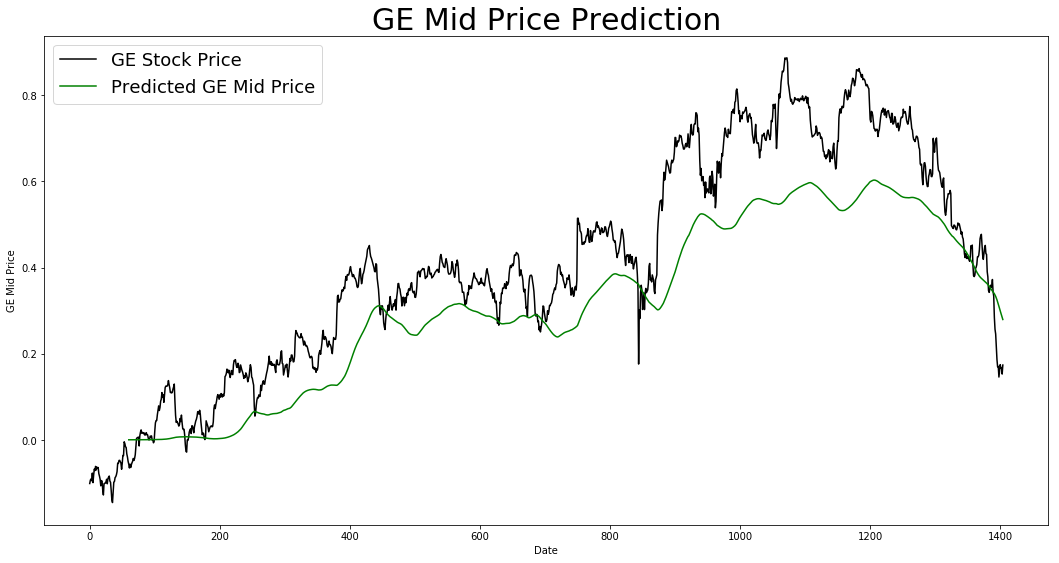

In [176]:
plt.figure(figsize = (18,9))
plt.plot(test_data, color = 'black', label = 'GE Stock Price')
plt.plot(predicted_stock_price_multi_head, color = 'green', label = 'Predicted GE Mid Price')
plt.title('GE Mid Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('GE Mid Price')
plt.legend(fontsize=18)
plt.show()

In [177]:
predicted_stock_price_multi_head = scaler.inverse_transform(predicted_stock_price_multi_head)



test_df['predicted_stock_price_multi_head'] = predicted_stock_price_multi_head

test_df['target_predictions_multi_head'] = list(map(classify, test_df[RATIO_TO_PREDICT], test_df['predicted_stock_price_multi_head']))



/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [178]:
accuracy_score(test_df['target'][61:], test_df['target_predictions_multi_head'][61:])

0.5148809523809523

In [179]:
for index, row in test_df[61:].iterrows():
    print(row["target_predictions_multi_head"])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
